This notebook reads the csv with the classifications of the different grids and then trains a CNN using fastai2. As a last step features are extracted which are then used for a ridge regression/random forest in R.

Start by installing fastai.

In [ ]:
!pip install -Uq fastai

Import necessary packages.

In [ ]:
import torch
from fastai.vision import *
from fastai.vision.all import *
import pandas as pd
from google.colab import drive
import shutil

Mount Google Drive to access the satellite images and the csv containing the classes of the images.

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Create a variable with the main directory we need, the data on the Google Drive.

In [ ]:
gdrive_data_path = '/content/gdrive/MyDrive/adb_poverty_elearning_module/data'

Now we read the csv, add a new column called "file_name" that consists of a six digit ID (with leading zeroes) and the suffix "jpg".

In addition, we make sure that our csv only contains grids for which we actually have images (e.g. there might be no images with less than 60% cloud cover in 2019 for a grid).

We output the first ten rows of the dataset to see what it looks like.

In [ ]:
grids_csv = gdrive_data_path + "/grids/indonesia_grids_classified.csv"
s2_path = gdrive_data_path + "/satellite_imagery/idn_east_java_s2_2019"

train_dataset = pd.read_csv(grids_csv)

train_dataset["file_name"] = train_dataset.apply(lambda x: f"{{:06d}}.jpg".format(x["id"]), axis=1)

image_files = os.listdir(s2_path)

train_dataset = train_dataset[train_dataset.file_name.isin(image_files)]

train_dataset.head(10)

Print an overview for the dataset, including infos on the different columns and on the sample itself.

In [ ]:
train_dataset.info()

Before we can start training the model, we need to define an [ImageDataLoader](https://docs.fast.ai/vision.data.html#imagedataloaders).

There are different parameters we need to set:


1.   df: Name of the data frame that contains information on the observations.
2.   path: Path pointing to the folder containing the images.
3.   valid_pct: Share of observations used for validation (as opposed to training).
4.   seed: Set a seed to make sure training and validation split are the same for different runs.
5.   fn_col: Name of the column that has the file name (of an image).
6.   label_col: Name of the column that contains the classification of an image (1 - low night light intensity, 2 - medium, 3 - high).
7.   bs: Batch size, the number of observations processed each round.
8.   num_workers: Number of workers, i.e. number of processes.
9.   batch_tmfs: Batch transformations applied to the images.



In [ ]:
data = ImageDataLoaders.from_df(
    df = train_dataset,
    path = s2_path,
    valid_pct = 0.2,
    seed = 42,
    fn_col = "file_name",
    label_col = "nl_class",
    bs = 32,
    num_workers = 5,
    batch_tfms=Normalize.from_stats(*imagenet_stats))

Show a batch of images including the corresponding classes.

In [ ]:
data.show_batch()

# Learning rate finder.

In neural networks the learning rate specifies how fast or slow a model "learns" (i.e. adjusts the different parameters). There is no universal learning rate that one can use for different datasets and problems as the optimal learning rate differs across problems and datasets.

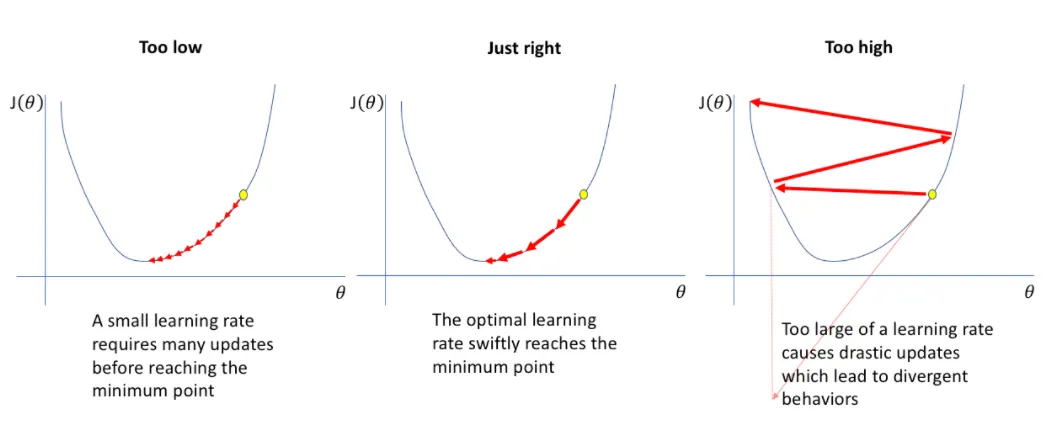

Source: [medium.com](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036)

Fortunately, fastai offers a learning rate finder that helps to specify the learning rate.

In [ ]:
learner = vision_learner(dls = data,
                         arch = resnet34)

learning_rates = learner.lr_find(num_it=1000, suggest_funcs=(minimum, steep, valley, slide))

The graph above can be divided into three zones:


1.   Shallow zone, where changing the learning rate has a minimal effect on loss (between 10e-07 and 10e-5).
2.   Linear zone, where we observe a quick drop in the loss function (between 10e-05 and 10e-03).
3.   Divergent zone, where the learning rate is too high, resulting in loss to bounce and ultimately diverge from the local minima (learning rate above 10e-02).

A good rule of thumb is to use a learning rate which is one order of magnitude less than the minimum of the loss (in the graph above this corresponds to "valley").

Per default most layers are frozen when using vision_learner. The idea is that our problems are generalizable to the point where the first layers will be the same across problems. Hence, we focus on training the last layers.

We use a SaveModelCallback to stick to the model with the best validation loss. If an epoch leads to a model with a smaller loss, we switch to that model, otherwise we keep the earlier model stored as "best one" (which we will use later on to extract the features for the images).

In [ ]:
learner.fit_one_cycle(10, learning_rates.valley,
                      cbs=SaveModelCallback (monitor='valid_loss', min_delta=0.0,
                                             fname='resnet34_long_training_java_grids_test_part_1', every_epoch=False, at_end=False,
                                             with_opt=True, reset_on_fit=True)
                     )

Check confusion matrix to see how well our model classifies the different images into the three classes. We would like to see as many observations on the main diagonal as possible.

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

Plot some results.

In [ ]:
learner.show_results(max_n=9)

Plot the 9 images with the highest losses (starting with the highest). In addition, predicted and actual class are also shown.

In [ ]:
interp.plot_top_losses(9, figsize=(15,15), largest=True)

Let's have a look at our model.

In [ ]:
learner.model

Remove last (linear) layer to get features instead of classes. We are not interested in the night light classification itself, but in the features that the network identifies.

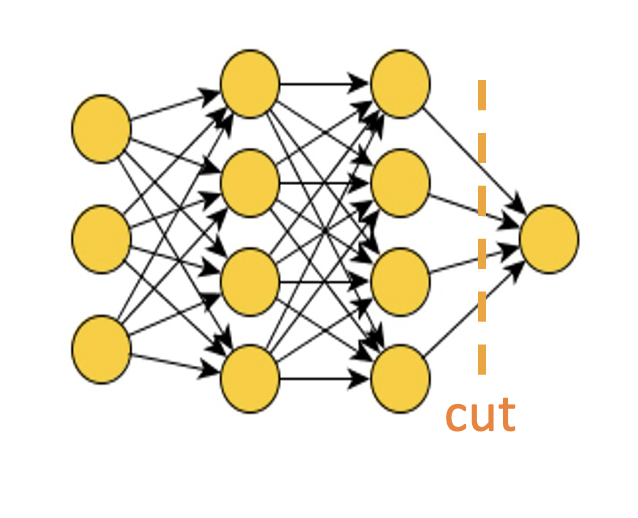

In [ ]:
learner.model[-1] = cut_model(learner.model[-1], -1)

Extract features for all images in our dataset using the trained model.

In [ ]:
features_out = np.empty((len(train_dataset["file_name"]), 512))
features_out_img = train_dataset["file_name"]
imagery_path = s2_path

# Loop through the images and extract the features.
for i, path_i in enumerate(features_out_img):
    # Open the image with the fastai open image function.
    temp_img = load_image(os.path.join(imagery_path, path_i))
    # Extract the features of the single image.
    temp_tensor = image2tensor(temp_img).to("cuda")
    # Convert the tensor to type float32.
    temp_tensor = torch.as_tensor(temp_tensor, dtype = torch.float32, device = "cuda")
    learner.model.eval() # to put BatchNorm in evaluation mode
    temp_features = learner.model(temp_tensor.unsqueeze(0))

    # store them for output
    features_out[i,:] = temp_features.detach().cpu().numpy()

Save features to a feather file (is more efficient/smaller than csv and can be read in R).

In [ ]:
features_out_pd = pd.DataFrame(data = features_out, index = features_out_img)

# Put index into separate column.
features_out_pd = features_out_pd.reset_index()
# Convert all column names to strings.
features_out_pd.columns = features_out_pd.columns.astype(str)

features_out_pd.to_feather(gdrive_data_path + "/extracted_features/features_east_java.feather")

Check how data frame with features looks like.

In [ ]:
features_out_pd